# Sonication analysis

In this notebook we analyze the difference of biomarker readout for sonicated and non-sonicated samples.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu


In [2]:
data = pd.read_csv('./data/sonication.csv', sep='\t', header=[0,1], index_col=0)

In [3]:
log_data = data.copy()
log_data = log_data.applymap(lambda x: np.log10(x) if pd.notnull(x) and x > 0 else np.nan)


/tmp/ipykernel_118117/3607805144.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_data = log_data.applymap(lambda x: np.log10(x) if pd.notnull(x) and x > 0 else np.nan)


In [4]:
# Resetting the index and properly renaming columns
log_data_reset = log_data.reset_index()
log_data_reset.columns = ['Sample ID'] + [f"{col[0]}_{col[1]}" for col in log_data_reset.columns[1:]]

# Melt the dataframe into long format
melted_data = log_data_reset.melt(
    id_vars=['Sample ID'],
    var_name="Biomarker_Sonication",
    value_name="Value"
)

# Split 'Biomarker_Sonication' into 'Biomarker' and 'Sonication'
melted_data[['Biomarker', 'Sonication']] = melted_data['Biomarker_Sonication'].str.split('_', expand=True)
melted_data.drop(columns='Biomarker_Sonication', inplace=True)



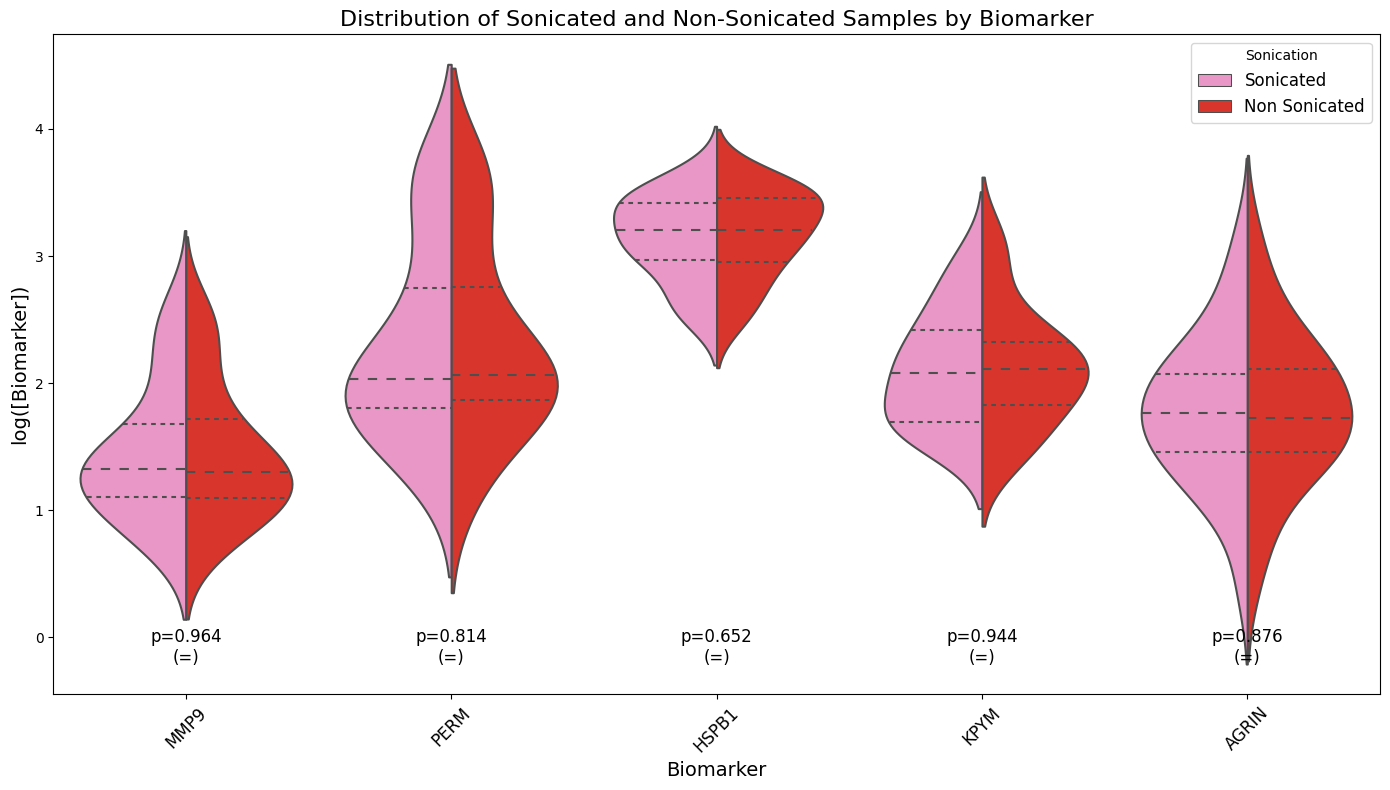

In [13]:
# Unique biomarkers
biomarkers = melted_data['Biomarker'].unique()

# Prepare the plot
plt.figure(figsize=(14, 8))
ax = sns.violinplot(
    data=melted_data,
    x="Biomarker",
    y="Value",
    hue="Sonication",
    split=True,
    inner="quart",
    palette=["#f789c8", "#f41c11"]
)

# Perform statistical tests and annotate
for i, biomarker in enumerate(biomarkers):
    # Extract data for each sonication group
    sonicated = melted_data[(melted_data['Biomarker'] == biomarker) & (melted_data['Sonication'] == 'Sonicated')]['Value'].dropna()
    non_sonicated = melted_data[(melted_data['Biomarker'] == biomarker) & (melted_data['Sonication'] == 'Non Sonicated')]['Value'].dropna()

    # Perform Mann-Whitney U test
    if len(sonicated) > 0 and len(non_sonicated) > 0:  # Ensure groups are not empty
        stat, p_value = mannwhitneyu(sonicated, non_sonicated)
        sign = "≠" if p_value < 0.05 else "="
        p_text = f"p={p_value:.3f}\n({sign})"

        # Annotate the plot
        x = i  # x-coordinate for the biomarker
        y = -0.2
        ax.annotate(p_text, (x, y), ha='center', fontsize=12, color='black')

# Customize the plot
plt.title("Distribution of Sonicated and Non-Sonicated Samples by Biomarker", fontsize=16)
plt.xlabel("Biomarker", fontsize=14)
plt.ylabel("log([Biomarker])", fontsize=14)
plt.legend(title="Sonication", loc="upper right", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

As can be observed, for all the biomarkers and the total protein, distributions looks very similar despite the sonication status. A Mann-Whitney test was executed confirming that they come from the same distribution.